# Transformar Shapefiles em Amostras para Machine Learning (ML)

__Autoria:__ Sabrina Paes Leme P. Correa (paeslemesa@gmail.com) <br>
__Criação:__ 15/04/2024 <br>
__Modificação:__ 15/04/2024

__Referências:__ 
* https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

Nesse tutorial vamos fazer o passo-a-passo para:
* Converter o arquivo shapefile em raster -> caso queira usar ele em algum outro software
* Usar este raster para criar um arquivo CSV com amostras para rodar em algoritmos de ML

## 1. Importando bibliotecas

In [92]:
from pathlib import Path #biblioteca para manipulação de arquivos, tipo a OS

import rasterio #biblioteca para manipulação de arquivos raster
import rasterio.mask #biblioteca para mascaramento de arquivos raster

import numpy as np #biblioteca para manipulação de arrays
import geopandas as gpd #biblioteca para manipulação de arquivos vetoriais

import pandas as pd #biblioteca para manipulação de dataframes

import matplotlib.pyplot as plt #biblioteca para plotar gráficos


## 2. Entrada de dados

Para a entrada de dados, vamos usar
* O shapefile que marcamos em cima da imagem para ser classificada. Nesse shapefile, precisamos ter marcado pelo menos o número da classe, como mostrado na imagem abaixo;
* A imagem (raster) da área de estudo que vamos trabalhar. O caso aqui é uma cena inteira do Sentinel-2 com as bandas Azul (B2), Verde (B3), Vermelho (B4) e Infravermelho Próximo (B8)

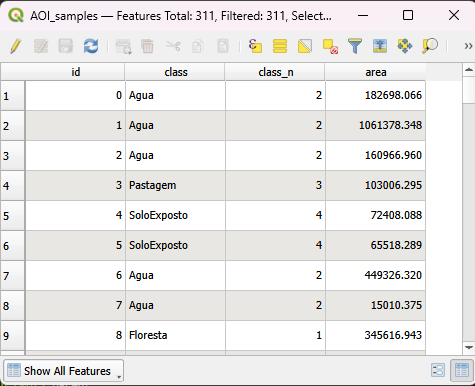


A criação do shapefile foi feita em software aberto QGIS.

In [29]:
wkdir = "./"

caminho_shp = Path(wkdir, "00_Dados/AOI_samples.shp")
caminho_img = Path(wkdir, "01_Imagens/Sentinel2/S2B_MSIL2A_20230819T135709_N0509_R067_T21MZR_20230819T181035.SAFE/S2B_MSIL2A_20230819T135709_N0509_R067_T21MZR_20230819T181035_MERGE.tif")

## 3. Rasterizando o shape

Em primiero momento, vamos ler nosso arquivo shapefile para entendermos como ele está organizado.

Usaremos o campo denominado <code>class_n</code> para assinalar valores a imagem

In [96]:
caminho_saida = Path(wkdir, "00_Dados/AOI_samples.tif") # determinar o nome do caminho de saída do raster
nome_campo = "class_n" # numero da classe que usaremos

In [30]:
gdf = gpd.read_file(caminho_shp) # lendo o arquivo shapefile
gdf.head() # visualizando as primeiras linhas do arquivo shapefile

,id,class,class_n,area,geometry
0,0,Agua,2,182698.066,"POLYGON ((867402.470 9508747.489, 868134.256 9..."
1,1,Agua,2,1061378.348,"POLYGON ((869155.996 9507822.401, 869556.408 9..."
2,2,Agua,2,160966.960,"POLYGON ((858278.149 9508054.823, 858427.728 9..."
3,3,Pastagem,3,103006.295,"POLYGON ((887034.143 9538778.358, 887195.228 9..."
4,4,SoloExposto,4,72408.088,"POLYGON ((889202.721 9538085.532, 889457.207 9..."


In [90]:
classes = np.unique(gdf[nome_campo]).astype(np.int32)
print("Números das classes:", classes)

Números das classes: [1 2 3 4]


Aqui embaixo vamos, de fato, rasterizar o shape com todas as classes que temos.

Vamos usar a função <code>crop</code> primeiro para recortar o raster de forma que só tenhamos informações de pixel ali no shape e vamos trocar os valores restantes pelo valor da classe que queremos. Também vamos substituir o valor <code>nodata</code> do Sentinel-2 que costuma ser 9999 por 0.

In [91]:
for i in classes:
    with rasterio.open(caminho_img) as src: # abrindo a imagem
        out_image, out_transform = rasterio.mask.mask(src, gdf.loc[gdf['class_n']==i].geometry, crop=False) # mascarando a imagem e não diminuindo o tamanho original dela
        out_meta = src.meta # pegando os metadados da imagem
    
    if i==0: # se for a primeira classe, cria o raster de saída
        raster_aoi = out_image[0,:,:].copy() # copia a primeira banda da imagem
        raster_aoi = np.where(raster_aoi == out_meta['nodata'] , 0, raster_aoi) # substitui os valores nodata por 0
        raster_aoi = np.where(raster_aoi > 0 , i , raster_aoi) # substitui os valores maiores que 0 pelo número da classe
    else:
        temp_aoi = out_image[0,:,:].copy() # copia a primeira banda da imagem
        temp_aoi = np.where(temp_aoi == out_meta['nodata'] , 0, temp_aoi) # substitui os valores nodata por 0
        temp_aoi = np.where(temp_aoi > 0 , i , temp_aoi) # substitui os valores maiores que 0 pelo número da classe
        raster_aoi = np.where(temp_aoi == i , i , raster_aoi) # substitui os valores da classe i no raster de saída

### 3.1 Conferindo os resultados

In [94]:
print("Valores unicos do raster de saída:", np.unique(raster_aoi))

Valores unicos do raster de saída: [0. 1. 2. 3. 4.]


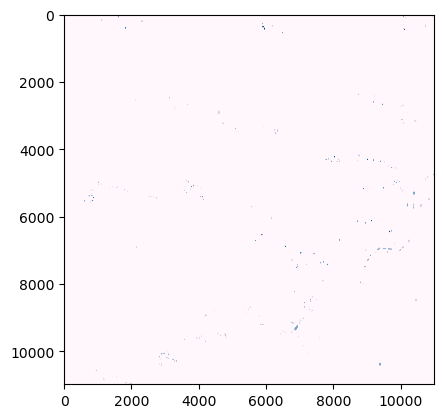

In [95]:
# Plotando o raster para conferir se faz sentido
plt.imshow(raster_aoi, cmap='PuBu')


### 3.2 Ajustando o array e salvando as classes

In [98]:
raster_aoi = raster_aoi.astype(np.uint8) # convertendo o raster para inteiro de 8 bits para deixar o arquivo de saída mais leve
out_meta.update( count = 1, nodata = 0, dtype = "uint8") # atualizando os metadados do arquivo de saída

Agora, para salvar as classes num imagem, basta usar a função abaixo.

Devemos considerar aqui que:
* <code> 'w'</code> significa "write", que é escrever em inglês
* <code>**out_meta</code> significa que estamos alocando várias informações (no caso, de um dicionário inteiro aqui aonde caberia uma coisa só)

In [99]:
with rasterio.open(caminho_saida, 'w', **out_meta) as dst: # criando o arquivo de saída
    dst.write(raster_aoi, 1) # escrevendo o raster de saída

## 4. Criando um dataframe para a entrada de dados

Vamos abrir a imagem que salvamos e a imagem original. Vou reabrí-las caso você escolha fazer isso em dois momentos.

O que vamso fazer aqui é criar um dataframe (uma tabela) com as informações de bandas e a classe

### 4.1. Abrindo as imagens e pegando as informações delas

In [103]:
with rasterio.open(caminho_saida) as src:# abrindo o arquivo de saída
    classes_img = src.read(1) # lendo o raster de saída

In [101]:
with rasterio.open(caminho_img) as src: # abrindo a imagem original
    imagem = src.read() # lendo a imagem original
    meta = src.meta # pegando os metadados da imagem original

In [107]:
array_amostras = np.where(classes_img > 0, imagem, 0) # criando um array com as amostras

### 4.2. Criando um dicionário de acordo com a ordem das bandas que estamo trabalhando.

Para cálculo de índices, tipo NDVI, podemos fazer isso facilmente depois :D

In [119]:
dicionario_amostras = {
    'classe':classes_img.flatten(),
    'azul':array_amostras[0].flatten(),
    'verde':array_amostras[1].flatten(),
    'vermelho':array_amostras[2].flatten(),
    'nir':array_amostras[3].flatten(),
}

In [113]:
df = pd.DataFrame(dicionario_amostras) # criando um dataframe com as amostras
df.head()

,classe,azul,verde,vermelho,nir
0,0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0


Agora vamos "limpar" o dataframe para que ele não tenha informações a mais do que precisamos. Por enquanto temos todas as informações da imagem inteira.

In [115]:
df = df[df['classe'] > 0] # removendo os pixels que não são amostras
df = df.reset_index(drop=True) # resetando o índice do dataframe
df.head()

,classe,azul,verde,vermelho,nir
0,1,1323.0,1467.0,1256.0,4272.0
1,1,1291.0,1460.0,1251.0,4213.0
2,1,1262.0,1460.0,1221.0,3980.0
3,1,1255.0,1438.0,1215.0,4216.0
4,1,1281.0,1429.0,1236.0,3646.0


Prontinho! Agora podemos calcular as estatísticas (análise exploratória, por exemplo) e adicionar novos índices com facilidade.

Podemos também ajustar nossas informações da banda do Sentinel-2.

In [120]:
df['azul'] = df['azul'] / 10000 # convertendo os valores de reflectância para valores de 0 a 1
df['verde'] = df['verde'] / 10000
df['vermelho'] = df['vermelho'] / 10000
df['nir'] = df['nir'] / 10000

df.head()

,classe,azul,verde,vermelho,nir,ndvi
0,1,0.1323,0.1467,0.1256,0.4272,0.545586
1,1,0.1291,0.1460,0.1251,0.4213,0.542094
2,1,0.1262,0.1460,0.1221,0.3980,0.530475
3,1,0.1255,0.1438,0.1215,0.4216,0.552569
4,1,0.1281,0.1429,0.1236,0.3646,0.493650


In [122]:
df['ndvi'] = (df['nir'] - df['vermelho']) / (df['nir'] + df['vermelho']) # calculando o NDVI
df.head()

,classe,azul,verde,vermelho,nir,ndvi
0,1,0.1323,0.1467,0.1256,0.4272,0.545586
1,1,0.1291,0.1460,0.1251,0.4213,0.542094
2,1,0.1262,0.1460,0.1221,0.3980,0.530475
3,1,0.1255,0.1438,0.1215,0.4216,0.552569
4,1,0.1281,0.1429,0.1236,0.3646,0.493650


Se quiser salvar o dataframe, podemos salvar ele como planilha do Excel ou como CSV.
Vou salvar ele como CSV como exemplo.

In [125]:
df.to_csv(Path(wkdir, "00_Dados/amostras_aoi.csv"), index=False) # salvando o arquivo de amostras

O resultado deve ser um bloco de notas como esse aqui: 

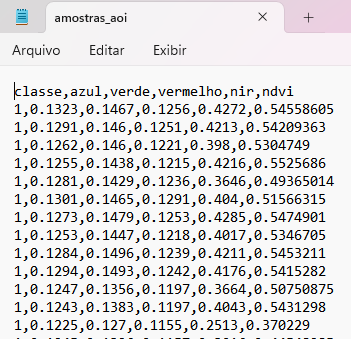